In [1]:
from datasets import load_dataset

Import the Dataset

In [2]:
dataset = load_dataset("json",data_files="economics.jsonl" , split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Formatting

In [3]:
def format_for_t5(example):
  instruction = example["instruction"]
  input_text = example.get("input","")
  return {
      "prompt": f"{instruction}\n{input_text}".strip(),
      "labels" : example["output"]
  }

In [4]:
formatted = dataset.map(format_for_t5)

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Import smolLM

In [5]:
model_name = "HuggingFaceTB/SmolLM2-360M"

In [6]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Tokenization

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [8]:
formatted

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'labels'],
    num_rows: 55
})

In [9]:
def tokenize(example):
    inputs = tokenizer(
        example["prompt"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    outputs = tokenizer(
        example["labels"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": outputs["input_ids"]
    }


In [10]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [11]:
tokenized_dataset = formatted.map(tokenize)

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

In [12]:
tokenized_dataset

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 55
})

Splitting

In [13]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

train = tokenized_dataset["train"]
eval = tokenized_dataset["test"]

In [14]:
train

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 44
})

Setting up training Arguments and Trainer

In [15]:
from transformers import TrainingArguments

In [16]:
training_args = TrainingArguments(
    output_dir="./checkpoints-smollm",
    num_train_epochs = 5,
    per_device_train_batch_size=2,
    learning_rate=5e-4,
    weight_decay=0.01,
    save_steps=10,
    logging_dir=".logs",
    logging_steps=1,
    report_to='none'
)

In [17]:
from transformers import Trainer

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=eval,
    tokenizer=tokenizer
)

/tmp/ipython-input-18-1957636794.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model Training

In [19]:
history = trainer.train()

Step,Training Loss
1,14.347800
2,12.006300
3,9.391200
4,9.361100
5,7.331100
6,6.984000
7,10.379900
8,7.897600
9,7.398400
10,8.043100


TrainOutput(global_step=110, training_loss=4.824847015399825, metrics={'train_runtime': 5068.2527, 'train_samples_per_second': 0.043, 'train_steps_per_second': 0.022, 'total_flos': 53160763392000.0, 'train_loss': 4.824847015399825, 'epoch': 5.0})

Save the model

In [20]:
model.save_pretrained("my-smollm")
tokenizer.save_pretrained("my-smollm")

('my-smollm/tokenizer_config.json',
 'my-smollm/special_tokens_map.json',
 'my-smollm/vocab.json',
 'my-smollm/merges.txt',
 'my-smollm/added_tokens.json',
 'my-smollm/tokenizer.json')

Testing

In [24]:
from transformers import pipeline

pipe = pipeline("text-generation", model="my-smollm", tokenizer="my-smollm")

Device set to use cpu


In [25]:
pipe("Why do developed countries want developing countries to liberalise their trade and investment?")

[{'generated_text': 'Why do developed countries want developing countries to liberalise their trade and investment? the in.. andCs production costs onCs the country in and. and competitiveness is in production in and and ( not 0  not  the the in  the  the developing.  production   in'}]

Visualize loss

In [26]:
logs = trainer.state.log_history

In [27]:
import matplotlib.pyplot as plt

steps = []
losses = []

for entry in logs:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])


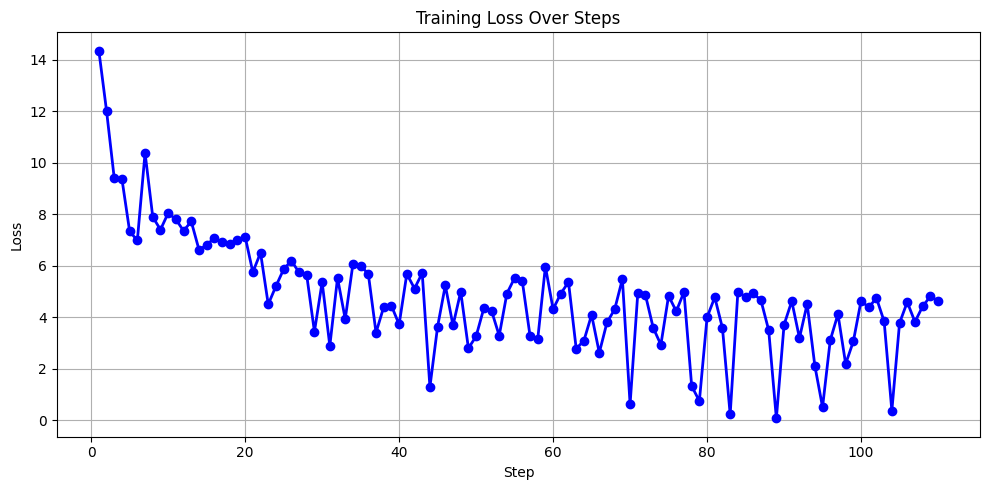

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', color='blue', linewidth=2)
plt.title("Training Loss Over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Download model

In [29]:
!zip -r my-smollm.zip my-smollm

  adding: my-smollm/ (stored 0%)
  adding: my-smollm/merges.txt (deflated 55%)
  adding: my-smollm/tokenizer.json (deflated 82%)
  adding: my-smollm/model.safetensors (deflated 7%)
  adding: my-smollm/config.json (deflated 49%)
  adding: my-smollm/vocab.json (deflated 59%)
  adding: my-smollm/generation_config.json (deflated 23%)
  adding: my-smollm/tokenizer_config.json (deflated 88%)
  adding: my-smollm/economics.jsonl (deflated 68%)
  adding: my-smollm/added_tokens.json (stored 0%)
  adding: my-smollm/special_tokens_map.json (deflated 76%)


In [30]:
from google.colab import files
files.download("my-smollm.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>